In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sn
from sklearn.linear_model import ElasticNet
import matplotlib.cm as cm

In [2]:
# link to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# data = pd.read_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_standardized.csv')
# data = pd.read_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_standardized_dum.csv')
# data = pd.read_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_standardized_pp_nosic.csv')
# data = pd.read_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_standardized_selection10.csv')
data = pd.read_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_mapped_selection10.csv')
data.index = data["date"]
data.index = pd.to_datetime(data.index)
data.drop(columns=["date"], inplace=True)
data.head()

,secid,-80,-50,-20,level,slope,curve,permno,mvel1,beta,...,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade
date,,,,,,,,,,,,,,,,,,,,,
1996-01-31,100862,0.307688,0.315627,0.358095,0.315627,0.042468,0.017264,54594,-0.994821,-0.502126,...,-0.997784,-0.999126,0.00,-0.689049,-0.775188,-0.662673,-0.619551,0.327234,-0.936622,-1.0
1996-01-31,100871,0.705411,0.615432,0.651160,0.615432,0.035728,0.062854,50906,-0.962567,0.551365,...,-0.998741,-0.999446,0.75,-0.112575,-0.989945,-0.390130,-0.223204,-0.342296,-0.748948,-1.0
1996-01-31,100892,0.270090,0.216768,0.216508,0.216768,-0.000260,0.026531,57904,-0.932091,-0.536730,...,-0.996865,-0.998628,0.25,-0.786859,-0.991139,-0.947305,-0.877289,-0.536138,-0.955821,-1.0
1996-01-31,100896,0.430796,0.436291,0.429517,0.436291,-0.006774,-0.006135,77520,-0.980594,0.349363,...,-0.965422,-0.985129,-0.25,-0.747736,-0.988896,-0.649524,-0.703492,-0.331142,-0.818216,-1.0
1996-01-31,100903,0.262405,0.252683,0.373839,0.252683,0.121156,0.065439,80303,-0.985699,-0.186662,...,-0.996865,-0.998628,-0.50,-0.807682,-0.970968,-0.825541,-0.737079,-0.400503,-0.866238,-1.0


Selecting training sample

In [ ]:
def samplesplitting(data,train,validate,oos,i):
    train_data    = data[(data.index.year >= 1996 )         & (data.index.year < i - validate)]
    validate_data = data[(data.index.year >= i - validate)  & (data.index.year < i)]
    total_train   = data[(data.index.year >= 1996 )         & (data.index.year < i)]
    oos_data      = data[(data.index.year == i)]
    pred_data     = data[(data.index.year >= 1996 + train + validate) & (data.index.year <= i)]

    print('train=%d, validate=%d, oos=%d' % (len(train_data), len(validate_data), len(oos_data)))
    return train_data, validate_data, oos_data, total_train, pred_data

# Loop sizes
trainsize = 11
validatesize = 5
oossize = 1
window = 2012

train, validate, oos, data_selection, total_oos = samplesplitting(data, trainsize, validatesize, oossize, window)
data_selection.tail()

train=210839, validate=158189, oos=33864


,secid,-80,-50,-20,level,slope,curve,permno,mvel1,beta,...,stdacc,stdcf,ms,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade
date,,,,,,,,,,,,,,,,,,,,,
2011-12-30,151720,0.217747,0.262343,0.331508,0.262343,0.069165,0.012285,13132,-0.993941,-0.17653,...,-0.999631,-0.999675,0.0,-0.435244,-0.998033,-0.646551,-0.469169,-0.671595,-0.890879,-1.0
2011-12-30,154591,0.185105,0.185725,0.187490,0.185725,0.001765,0.000572,13126,-0.993941,-0.17653,...,-0.999631,-0.999675,0.0,-0.435244,-0.998033,-0.646551,-0.469169,-0.671595,-0.890879,-1.0
2011-12-30,151413,0.412657,0.368014,0.399442,0.368014,0.031428,0.038035,13142,-0.993941,-0.17653,...,-0.999631,-0.999675,0.0,-0.435244,-0.998033,-0.646551,-0.469169,-0.671595,-0.890879,-1.0
2011-12-30,151427,1.123724,0.749264,0.811441,0.749264,0.062177,0.218318,13169,-0.993941,-0.17653,...,-0.999631,-0.999675,0.0,-0.435244,-0.998033,-0.646551,-0.469169,-0.671595,-0.890879,-1.0
2011-12-30,151076,0.215408,0.242377,0.405556,0.242377,0.163179,0.068105,13092,-0.993941,-0.17653,...,-0.999631,-0.999675,0.0,-0.435244,-0.998033,-0.646551,-0.469169,-0.671595,-0.890879,-1.0


ElasticNet

Number of features set to zero for  level  are:  64
30  features remaining.
Index(['beta', 'betasq', 'dolvol', 'idiovol', 'turn', 'absacc', 'age', 'bm_ia',
       'convind', 'dy', 'ep', 'mve_ia', 'orgcap', 'ps', 'rd', 'rd_mve', 'roic',
       'secured', 'securedind', 'tang', 'cash', 'cinvest', 'roaq', 'roavol',
       'ms', 'baspread', 'maxret', 'retvol', 'std_dolvol', 'std_turn'],
      dtype='object')


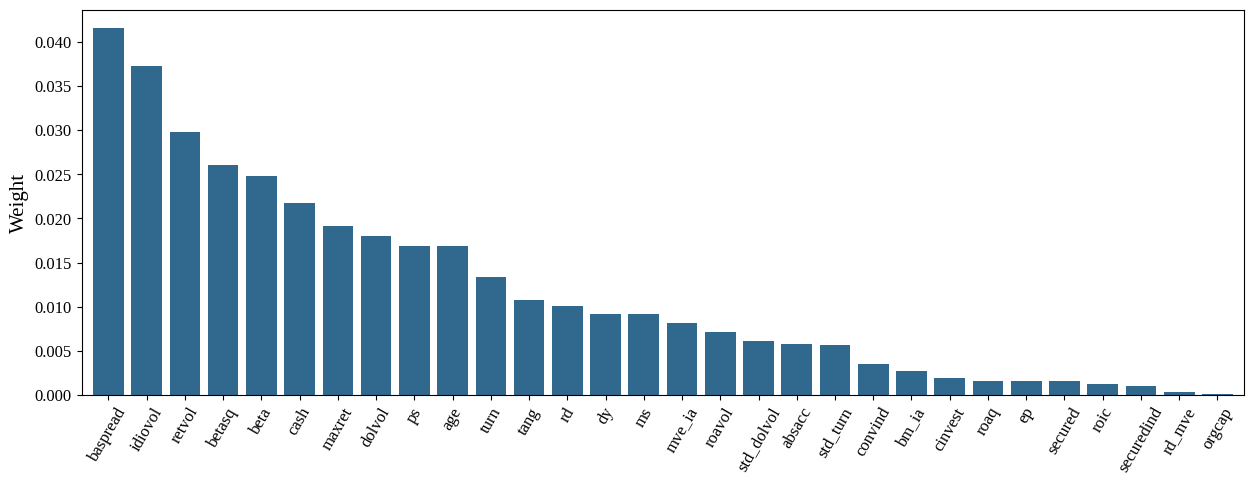

Number of features set to zero for  slope  are:  54
40  features remaining.
Index(['betasq', 'dolvol', 'idiovol', 'indmom', 'turn', 'absacc', 'bm',
       'bm_ia', 'cashdebt', 'cashpr', 'cfp', 'chcsho', 'chempia', 'convind',
       'depr', 'ep', 'grcapx', 'hire', 'mve_ia', 'orgcap', 'pchcapx_ia',
       'pchsale_pchinvt', 'rd', 'rd_mve', 'roic', 'salerec', 'secured',
       'securedind', 'tang', 'tb', 'cash', 'roaq', 'roavol', 'roeq', 'rsup',
       'baspread', 'maxret', 'retvol', 'std_dolvol', 'std_turn'],
      dtype='object')


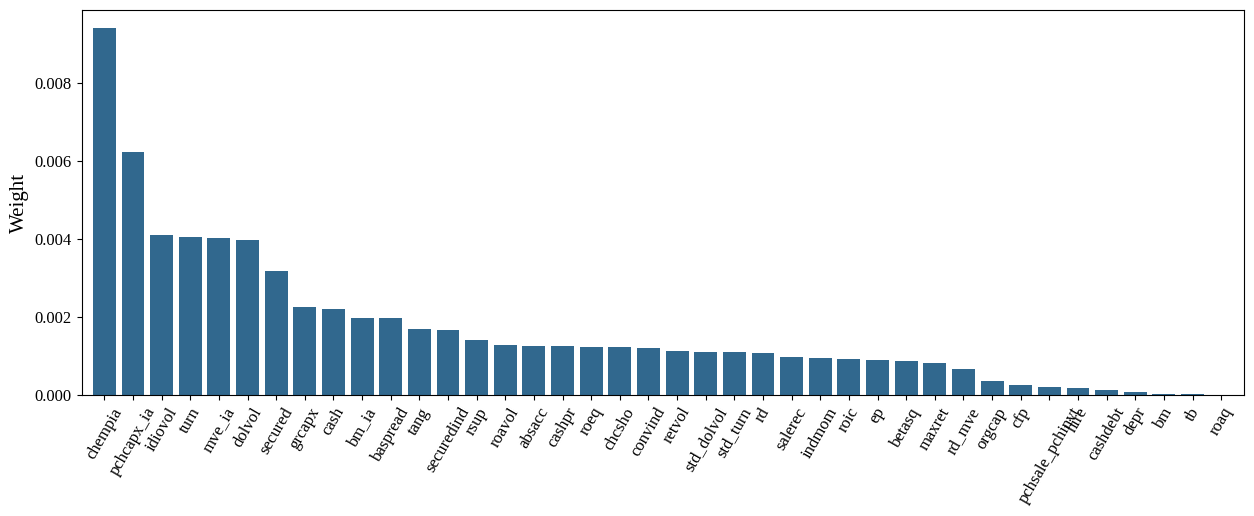

Number of features set to zero for  curve  are:  54
40  features remaining.
Index(['betasq', 'dolvol', 'idiovol', 'indmom', 'turn', 'absacc', 'bm',
       'bm_ia', 'cashpr', 'cfp', 'cfp_ia', 'chcsho', 'chempia', 'convind',
       'depr', 'dy', 'grcapx', 'mve_ia', 'operprof', 'orgcap', 'pchcapx_ia',
       'pchsale_pchinvt', 'rd', 'rd_mve', 'roic', 'salerec', 'secured',
       'securedind', 'tang', 'cash', 'cinvest', 'roavol', 'roeq', 'rsup', 'ms',
       'baspread', 'maxret', 'retvol', 'std_dolvol', 'std_turn'],
      dtype='object')


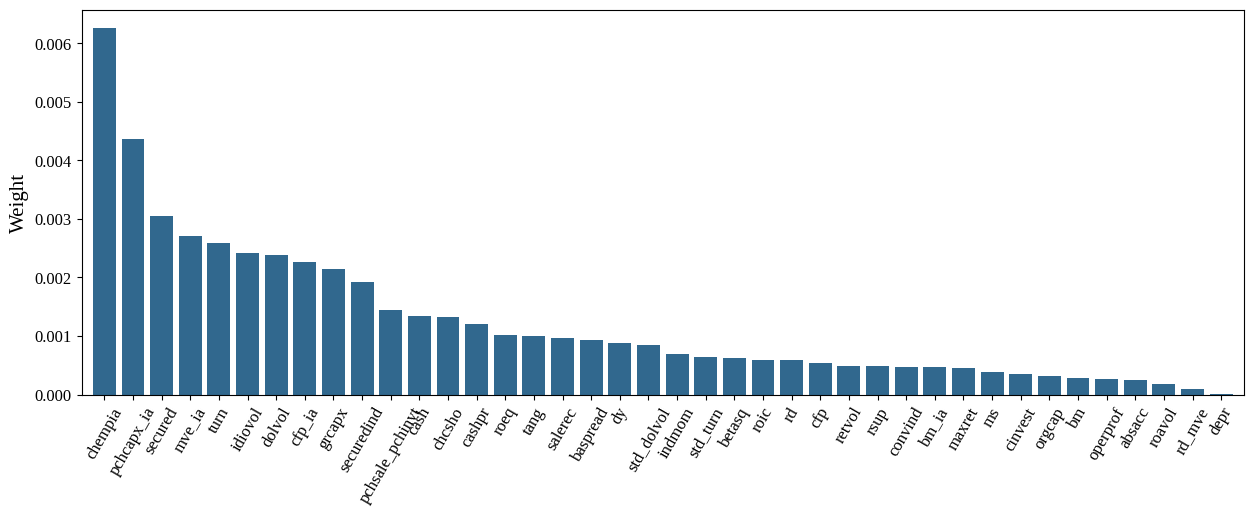

In [13]:
def feature_selection(IV, data, l1_ratio):
  data_y, features = data[IV], data.iloc[:,8:]

  enet_model = ElasticNet( alpha=0.5, l1_ratio=l1_ratio)
  enet_model.fit(features, data_y)
  coef = enet_model.coef_
  zero_features = np.where(coef == 0)[0]
  print("Number of features set to zero for ", IV, " are: ", zero_features.shape[0])
  print(94 - zero_features.shape[0], " features remaining.")
  # print(169 - zero_features.shape[0], " features remaining.")
  mask = enet_model.coef_!=0
  selected_features = features.columns[mask]
  print(selected_features)

  features_elnet = pd.DataFrame(data = np.absolute(enet_model.coef_[mask]), columns = ["Importance"])
  features_elnet.index = selected_features
  sorted_features_elnet = features_elnet.sort_values(by = "Importance", ascending=False)

  colors = cm.viridis(np.linspace(0, 1, 7))
  font_name = 'Liberation Serif'
  plt.figure(figsize=(15, 5))
  plt.bar(sorted_features_elnet.index, sorted_features_elnet["Importance"], color=colors[2])
  # plt.xlabel("Features", fontsize=10)
  plt.ylabel("Weight", fontsize=15, fontname = font_name)
  plt.xticks(rotation=60)
  plt.xticks(rotation=60, fontname=font_name, fontsize=12)
  plt.yticks(fontname=font_name, fontsize=12)
  plt.margins(x=0.01)
  plt.show()
  return selected_features.to_numpy()

#Values without dummies (data_standardized.csv)
# level_features = feature_selection('level', data, 0.027)
# slope_features = feature_selection('slope', data, 09.00745)
# curve_features = feature_selection('curve', data, 0.00475)

# #Values with dummies (data_standardized_dum.csv)
# level_features = feature_selection('level', data, 0.030)
# slope_features = feature_selection('slope', data, 0.0052)
# curve_features = feature_selection('curve', data, 0.003)

# #Values without dummies, standardised per period (data_standardized_pp_nosic.csv)
# level_features = feature_selection('level', data, 0.028)
# slope_features = feature_selection('slope', data, 0.00447)
# curve_features = feature_selection('curve', data, 0.00285)

#Values without dummies, standardised per period (data_standardized_selection10.csv) (30,40,40) --> vgm mapped
level_features = feature_selection('level', data_selection, 0.0112)
slope_features = feature_selection('slope', data_selection, 0.00155)
curve_features = feature_selection('curve', data_selection, 0.00125)

# #Values without dummies, standardised per period (data_standardized_selection10.csv) (30,30,30)
# level_features = feature_selection('level', data, 0.014)
# slope_features = feature_selection('slope', data, 0.0025)
# curve_features = feature_selection('curve', data, 0.0019)


# np.savetxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/level_f.csv', level_features, fmt='%s')
# np.savetxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/slope_f.csv', slope_features, fmt='%s')
# np.savetxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/curve_f.csv', curve_features, fmt='%s')

# np.savetxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/level_f_dum_20.csv', level_features, fmt='%s')
# np.savetxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/slope_f_dum_20.csv', slope_features, fmt='%s')
# np.savetxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/curve_f_dum_20.csv', curve_features, fmt='%s')

# np.savetxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/level_f_selection10.csv', level_features, fmt='%s')
# np.savetxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/slope_f_selection10.csv', slope_features, fmt='%s')
# np.savetxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/curve_f_selection10.csv', curve_features, fmt='%s')

In [ ]:
level_features = np.loadtxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/level_f.csv', dtype='str').tolist()
slope_features = np.loadtxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/slope_f.csv', dtype='str').tolist()
curve_features = np.loadtxt('/content/drive/MyDrive/Msc Thesis/code/Feature selection/curve_f.csv', dtype='str').tolist()

Create standardised datasets for level, slope and curvature

In [ ]:
data_level = data[data.columns[:8].tolist() + level_features]
data_slope = data[data.columns[:8].tolist() + slope_features]
data_curve = data[data.columns[:8].tolist() + curve_features]

data_level.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_level_standardized.csv', index=True)
data_curve.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_curve_standardized.csv', index=True)
data_slope.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_slope_standardized.csv', index=True)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_standardized_selection10.csv')
data.index = data["date"]
data.index = pd.to_datetime(data.index)
data.drop(columns=["date"], inplace=True)

data_level = data[data.columns[:8].tolist() + level_features.tolist()]
data_slope = data[data.columns[:8].tolist() + slope_features.tolist()]
data_curve = data[data.columns[:8].tolist() + curve_features.tolist()]

# data_level.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_level_standardized_dum_20.csv', index=True)
# data_curve.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_curve_standardized_dum_20.csv', index=True)
# data_slope.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_slope_standardized_dum_20.csv', index=True)

# data_level.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_level_standardized_pp_nosic.csv', index=True)
# data_curve.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_curve_standardized_pp_nosic.csv', index=True)
# data_slope.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_slope_standardized_pp_nosic.csv', index=True)

data_level.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_level_standardized_selection10.csv', index=True)
data_curve.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_curve_standardized_selection10.csv', index=True)
data_slope.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_slope_standardized_selection10.csv', index=True)

Create mapped datasets for level, slope and curvature

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_mapped.csv')
data.index = data["date"]
data.index = pd.to_datetime(data.index)
data.drop(columns=["date"], inplace=True)

data_level = data[data.columns[:8].tolist() + level_features]
data_slope = data[data.columns[:8].tolist() + slope_features]
data_curve = data[data.columns[:8].tolist() + curve_features]

data_level.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_level_mapped.csv', index=True)
data_curve.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_curve_mapped.csv', index=True)
data_slope.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_slope_mapped.csv', index=True)

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_mapped_dum.csv')
# data = pd.read_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_mapped_pp_nosic.csv')
data = pd.read_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_mapped_selection10.csv')
data.index = data["date"]
data.index = pd.to_datetime(data.index)
data.drop(columns=["date"], inplace=True)

data_level = data[data.columns[:8].tolist() + level_features.tolist()]
data_slope = data[data.columns[:8].tolist() + slope_features.tolist()]
data_curve = data[data.columns[:8].tolist() + curve_features.tolist()]

# data_level.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_level_mapped_dum20.csv', index=True)
# data_curve.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_curve_mapped_dum20.csv', index=True)
# data_slope.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_slope_mapped_dum20.csv', index=True)

# data_level.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_level_mapped_pp_nosic.csv', index=True)
# data_curve.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_curve_mapped_pp_nosic.csv', index=True)
# data_slope.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_slope_mapped_pp_nosic.csv', index=True)

data_level.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_level_mapped_selection10.csv', index=True)
data_curve.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_curve_mapped_selection10.csv', index=True)
data_slope.to_csv('/content/drive/MyDrive/Msc Thesis/code/data/Low resolution/data_slope_mapped_selection10.csv', index=True)

In [ ]:
data_level.head()

In [ ]:
data_slope.head()

In [ ]:
data_curve.head()